# XGBoost

#### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from scipy import stats

### Read the data

In [3]:
# read the data
#df = pd.read_csv("../data/total_dry_no_labels.csv", index_col=0)
df = pd.read_csv("../data/total_dry_no_info.csv", index_col=0)
df.columns = df.columns.str.replace(' ', '')
#df = df.head(100000)
#df.drop('network_count', axis=1, inplace=True)

/home/geanderson/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,4,5,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### Prepare the data

In [4]:
# delete unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# convert all columns of DataFrame
df = df.dropna()
# find the objects columns
cols = df.columns[df.dtypes.eq('object')]
# convert to numeric these columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [5]:
# check the shape
df.shape

(601076, 47)

#### Create X features and Y target

In [7]:
# split data into X and y
array = df.values
X = array[:,0:46]
Y = array[:,46]

In [8]:
# split data into train and test sets
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#### Create the model

In [9]:
# fit model no training data
model = XGBRegressor(n_estimators=100,
                    learning_rate = .1,
                    max_depth = 6,
                    random_state=42,
                    n_jobs = -1,
                    early_stopping_rounds=10)

In [10]:
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",
    eval_set=[(X_test, y_test)],
    verbose=True)

[13:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:30.9476
[1]	validation_0-rmse:27.9714
[2]	validation_0-rmse:25.2969
[3]	validation_0-rmse:22.8911
[4]	validation_0-rmse:20.7444
[5]	validation_0-rmse:18.8171
[6]	validation_0-rmse:17.094
[7]	validation_0-rmse:15.5593
[8]	validation_0-rmse:14.1894
[9]	validation_0-rmse:12.9695
[10]	validation_0-rmse:11.8721
[11]	validation_0-rmse:10.9035
[12]	validation_0-rmse:10.0465
[13]	validation_0-rmse:9.29177
[14]	validation_0-rmse:8.62747
[15]	validation_0-rmse:8.04367
[16]	validation_0-rmse:7.51761
[17]	validation_0-rmse:7.0479
[18]	validation_0-rmse:6.64787
[19]	validation_0-rmse:6.30557
[20]	validation_0-rmse:6.00117
[21]	validation_0-rmse:5.67105
[22]	validation_0-rmse:5.39659
[23]	validation_0-rmse:5.19366
[24]	validation_0-rmse:4.9814
[25]	validation_0-rmse:4.83151
[26]	validation_0-rmse:4.66193
[27]	validation_0-rmse:4.55668
[28]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
       gamma=0, importance_type='gain', learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [11]:
preds = model.predict(X_test)

In [12]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.142491


#### Cross-Validation

In [13]:
X, y = df.iloc[:,:-1],df.iloc[:,-1]

In [14]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

/home/geanderson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/geanderson/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [15]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [16]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True, seed=seed)

[13:11:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
print((cv_results["test-rmse-mean"]).tail(1))

49    4.654392
Name: test-rmse-mean, dtype: float64


#### Feature Importance

In [18]:
model = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[13:11:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


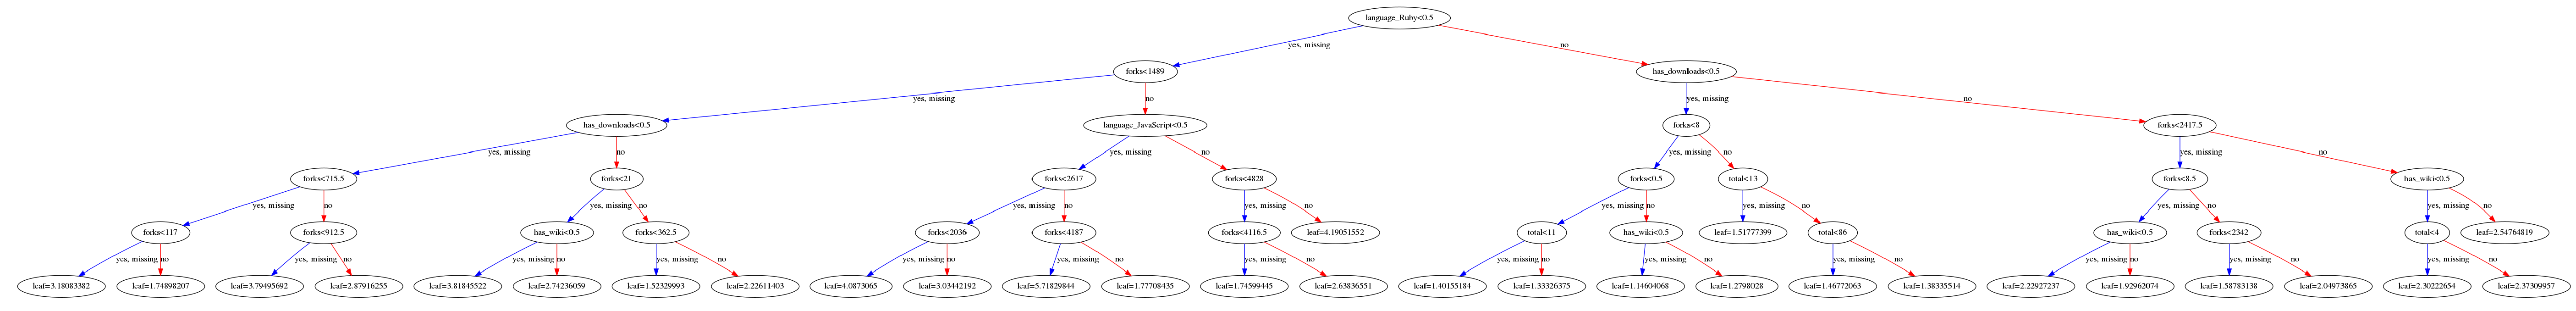

In [21]:
import matplotlib.pyplot as plt

xgb.plot_tree(model,num_trees=1)
fig = plt.gcf()
fig.set_size_inches(100, 100)
#plt.rcParams['figure.figsize'] = [100, 100]
plt.savefig('../reports/tree.png')
plt.show()

In [23]:
df.shape

(601076, 47)